# Generating stats and plots for the auglab demo

In [31]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../")

import utils
from db import HindsightDB

In [20]:
import tzlocal
from zoneinfo import ZoneInfo

local_timezone = tzlocal.get_localzone()
video_timezone = ZoneInfo("UTC")

# Get computer Frames

In [94]:
rem_db_path = "/Users/connorparish/Library/Containers/today.jason.rem/Data/Library/Application Support/today.jason.rem/db.sqlite3"
rem_conn = sqlite3.connect(rem_db_path)

In [6]:
query = f"""SELECT * from chunks_frames_view"""
rem_df = pd.read_sql(query, rem_conn)

In [24]:
rem_df['source'] = "computer"
rem_df['datetime_utc'] = pd.to_datetime(rem_df['timestamp'])
rem_df['datetime_local'] = rem_df['datetime_utc'].apply(lambda x: x.replace(tzinfo=video_timezone).astimezone(local_timezone))

# Get phone frames

In [9]:
db = HindsightDB()

In [10]:
phone_frames = db.get_frames()

In [15]:
phone_frames['source'] = "phone"
phone_frames = utils.add_datetimes(phone_frames)

# Combine frames

In [25]:
frames = pd.concat([rem_df, phone_frames])

In [26]:
frames = frames.sort_values(by='datetime_local')

In [29]:
frames['cumulative_count'] = frames.groupby('source').cumcount() + 1

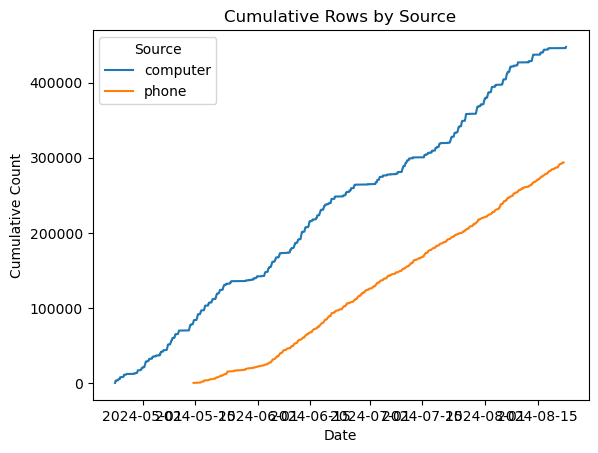

In [32]:
fig, ax = plt.subplots()
for source, group in frames.groupby('source'):
    ax.plot(group['datetime_local'], group['cumulative_count'], label=source)

ax.set_title('Cumulative Rows by Source')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Count')
ax.legend(title='Source')
plt.show()

In [34]:
frames_pivot = frames.pivot_table(index='datetime_local', columns='source', aggfunc='size', fill_value=0)
cumulative = frames_pivot.cumsum()

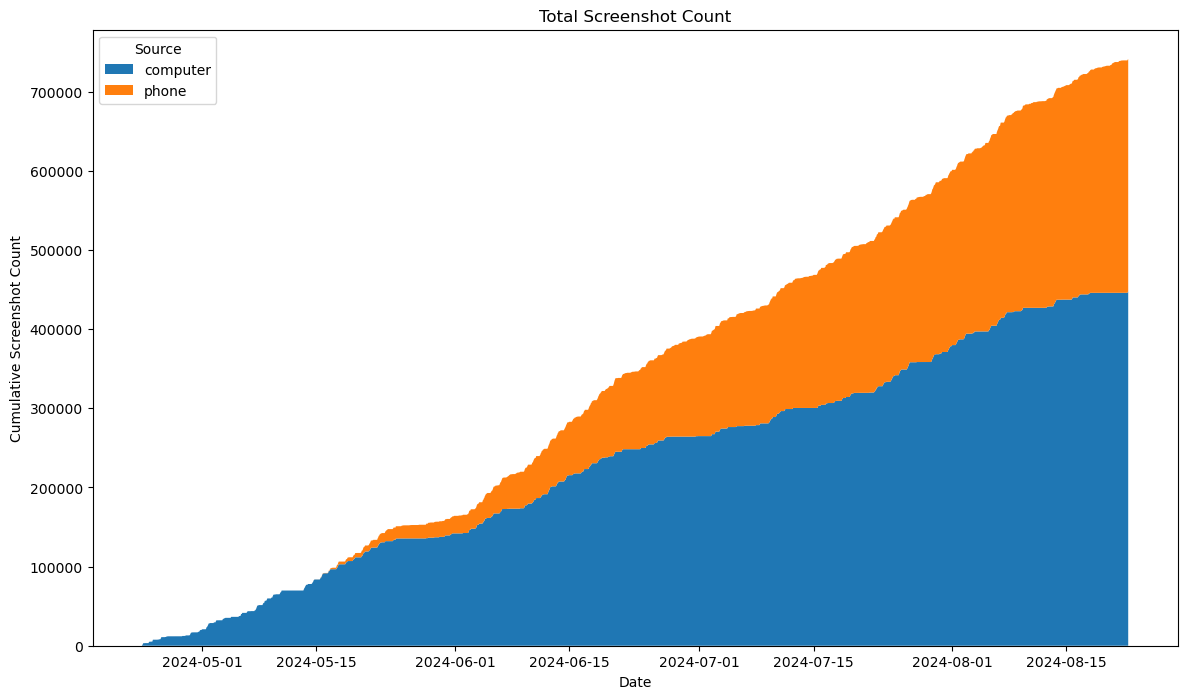

In [38]:
fig, ax = plt.subplots(figsize=(14,8))
ax.stackplot(cumulative.index, cumulative.T, labels=cumulative.columns)
ax.set_title('Total Screenshot Count')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Screenshot Count')
ax.legend(title='Source', loc='upper left')
plt.show()

# Get Total Unique Word Count

In [56]:
phone_frames['time_bin'] = phone_frames['datetime_local'].dt.to_period('W')
phone_frames_grouped = phone_frames.groupby('time_bin').agg(     
                                        frame_ids=('id', list),      
                                    ).reset_index()

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_12973/1190241005.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  phone_frames['time_bin'] = phone_frames['datetime_local'].dt.to_period('W')


In [97]:
def get_frames_with_ocr_unique(frame_ids=None):
    """Select the first occurrence of each distinct OCR text along with frame IDs and timestamps, 
    using SQL window functions for efficient deduplication."""
    with db.get_connection() as conn:
        # Query to get the first unique OCR text for each frame ID based on earliest timestamp
        query = '''
            WITH RankedResults AS (
                SELECT 
                    frames.id as frame_id,
                    ocr_results.text,
                    frames.timestamp,
                    ROW_NUMBER() OVER (PARTITION BY ocr_results.text ORDER BY frames.timestamp ASC) as rank
                FROM frames
                INNER JOIN ocr_results ON frames.id = ocr_results.frame_id
                '''
        if frame_ids:
            placeholders = ','.join(['?'] * len(frame_ids))  # Create placeholders for the query
            query += f" WHERE frames.id IN ({placeholders})"

        query += '''
            )
            SELECT frame_id, text, timestamp
            FROM RankedResults
            WHERE rank = 1
        '''

        # Use pandas to read the SQL query result into a DataFrame
        df = pd.read_sql_query(query, conn, params=tuple(frame_ids) if frame_ids else None)


        return df

def get_rem_frames_with_ocr_unique(frame_ids=None):
    """Select the first occurrence of each distinct OCR text along with frame IDs and timestamps, 
    using SQL window functions for efficient deduplication."""
    # Query to get the first unique OCR text for each frame ID based on earliest timestamp
    query = '''
        WITH RankedResults AS (
            SELECT 
                frames.id as frame_id,
                frames_text.text,
                frames.timestamp,
                ROW_NUMBER() OVER (PARTITION BY frames_text.text ORDER BY frames.timestamp ASC) as rank
            FROM frames
            INNER JOIN frames_text ON frames.id = frames_text.frameId
            '''
    if frame_ids:
        placeholders = ','.join(['?'] * len(frame_ids))  # Create placeholders for the query
        query += f" WHERE frames.id IN ({placeholders})"

    query += '''
        )
        SELECT frame_id, text, timestamp
        FROM RankedResults
        WHERE rank = 1
    '''

    # Use pandas to read the SQL query result into a DataFrame
    df = pd.read_sql_query(query, rem_conn, params=tuple(frame_ids) if frame_ids else None)


    return df


In [98]:
rem_frames_ocr_res = get_rem_frames_with_ocr_unique()

In [101]:
rem_frames_ocr_res['datetime_utc'] = pd.to_datetime(rem_frames_ocr_res['timestamp'])
rem_frames_ocr_res['datetime_local'] = rem_frames_ocr_res['datetime_utc'].apply(lambda x: x.replace(tzinfo=video_timezone).astimezone(local_timezone))

In [102]:
phone_frames_ocr_res = get_frames_with_ocr_unique()

In [103]:
phone_frames_ocr_res = utils.add_datetimes(phone_frames_ocr_res)

In [104]:
frames_ocr_res = pd.concat([rem_frames_ocr_res, phone_frames_ocr_res])

In [105]:
frames_ocr_res = frames_ocr_res.sort_values(by='datetime_local')

In [106]:
frames_ocr_res['time_bin'] = frames_ocr_res['datetime_local'].dt.to_period('W')
frames_ocr_res['text'] = frames_ocr_res['text'].str.lower()
frames_ocr_res_grouped = frames_ocr_res.groupby('time_bin').agg(     
                                        text_groups=('text', list),      
                                    ).reset_index()

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_12973/2344276910.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  frames_ocr_res['time_bin'] = frames_ocr_res['datetime_local'].dt.to_period('W')


In [107]:
total_unique_words = set()
bin_to_words_count = {}
for i, row in frames_ocr_res_grouped.iterrows():
    group_words = set()
    for text_group in row['text_groups']:
        if text_group is None:
            continue
        for w in text_group.split(' '):
            group_words.add(w)
    total_unique_words.update(group_words)
    print(row['time_bin'], len(total_unique_words))
    bin_to_words_count[row['time_bin']] = len(total_unique_words)

2024-04-29/2024-05-05 57272
2024-05-06/2024-05-12 120043
2024-05-13/2024-05-19 217963
2024-05-20/2024-05-26 273517
2024-05-27/2024-06-02 303852
2024-06-03/2024-06-09 394982
2024-06-10/2024-06-16 511891
2024-06-17/2024-06-23 562084
2024-06-24/2024-06-30 602482
2024-07-01/2024-07-07 635992
2024-07-08/2024-07-14 680448
2024-07-15/2024-07-21 741034
2024-07-22/2024-07-28 813122
2024-07-29/2024-08-04 884148
2024-08-05/2024-08-11 934576
2024-08-12/2024-08-18 968120
2024-08-19/2024-08-25 971724


In [121]:
series = pd.Series(bin_to_words_count)

series.index = series.index.map(lambda p: p.end_time.date())

# Ensure the series is sorted by index (the Periods)
series.sort_index(inplace=True)

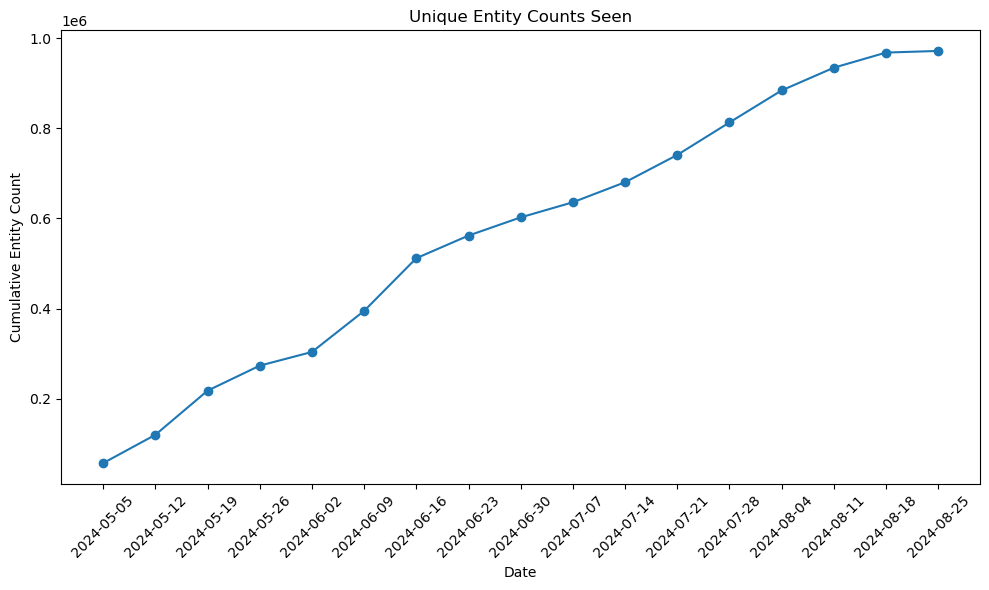

In [124]:
plt.figure(figsize=(10, 6))  # Optional: Specify the figure size
plt.plot(series.index.astype(str), series.values, marker='o')  # Convert index to string for better tick formatting
plt.title('Unique Entity Counts Seen')
plt.xlabel('Date')
plt.ylabel('Cumulative Entity Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

# Try checking if word

In [131]:
import nltk
nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package words to
[nltk_data]     /Users/connorparish/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [133]:
word_list = set(words.words())
def is_valid_word(word):
   return word.lower() in word_list

In [137]:
total_unique_words = set()
bin_to_words_count = {}
for i, row in frames_ocr_res_grouped.iterrows():
    group_entities = set()
    for text_group in row['text_groups']:
        if text_group is None:
            continue
        for w in text_group.split(' '):
            group_entities.add(w)
    group_words = {e for e in group_entities if is_valid_word(e)}
    total_unique_words.update(group_words)
    print(row['time_bin'], len(total_unique_words))
    bin_to_words_count[row['time_bin']] = len(total_unique_words)

2024-04-29/2024-05-05 4973
2024-05-06/2024-05-12 8399
2024-05-13/2024-05-19 10576
2024-05-20/2024-05-26 12577
2024-05-27/2024-06-02 13563
2024-06-03/2024-06-09 15660
2024-06-10/2024-06-16 17515
2024-06-17/2024-06-23 18529
2024-06-24/2024-06-30 19352
2024-07-01/2024-07-07 19828
2024-07-08/2024-07-14 20445
2024-07-15/2024-07-21 21294
2024-07-22/2024-07-28 22099
2024-07-29/2024-08-04 22760
2024-08-05/2024-08-11 23251
2024-08-12/2024-08-18 23721
2024-08-19/2024-08-25 23826


In [138]:
series = pd.Series(bin_to_words_count)

series.index = series.index.map(lambda p: p.end_time.date())

# Ensure the series is sorted by index (the Periods)
series.sort_index(inplace=True)

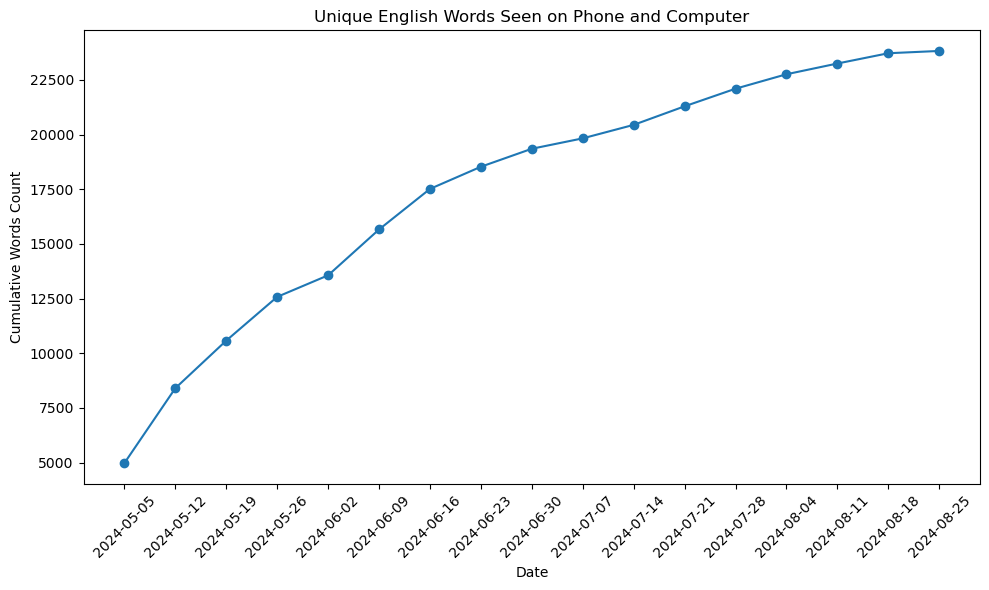

In [141]:
plt.figure(figsize=(10, 6))  # Optional: Specify the figure size
plt.plot(series.index.astype(str), series.values, marker='o')  # Convert index to string for better tick formatting
plt.title('Unique English Words Seen on Phone and Computer')
plt.xlabel('Date')
plt.ylabel('Cumulative Words Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
# 258053, 257249, 250945, 252639

In [153]:
phone_frames.loc[phone_frames['id'] == 258053].iloc[0]['path']

'/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/08/04/frontCamera/frontCamera_1722739276629.jpg'